<a href="https://colab.research.google.com/github/physicsllama/instrument-detector/blob/main/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary remarks and ideas


In [1]:
# Goal: AI that recognizes similarity between songs. It'll give a list of similar songs to one.
# Maybe a good first thing is to do a clustering thing, where it just categorizes by genre.

#Maybe better goal: shazam but for recognizing songs from singing of a melody (NLR useful?)
# Try supervised ML, but also unsupervised.

# final goal: use technique from MIT course to swipe thru song?

In [2]:
# First need a database with songs. Start out with something simple, and short audio things
# Then need to process data. Will I need to Fourier transform/something like that, or can I just feed it into the network?

In [ ]:
''' Some beginning things:

1) Take down data from wav files. Use files containing a single note, played with a pitch fork
and also played with different instruments. Compare the data. Take Fourier transform. Try
to find what note it is from this. Try to deduce instrument playing the note! Normalize stuff to have same volume, same length of audio, etc

samples: notes from different instruments https://philharmonia.co.uk/resources/sound-samples/

2) Take down data from more complicated files (e.g., 5 seconds).

3) Get a sense of how big a neural network I need to represent data from a song
(how many inputs are there?)

4) Process data for set of songs from different genres (e.g. 3 each from classical,
hard rock, pop, and rap) 

'''


'''
Useful: https://www.tensorflow.org/io/tutorials/audio

https://www.altexsoft.com/blog/audio-analysis/





Audio sources: 
https://freesound.org/browse/packs/?order=-last_updated

https://bigsoundbank.com/search

https://research.google.com/audioset/index.html

'''

'\nUseful: https://www.tensorflow.org/io/tutorials/audio\n\nhttps://www.altexsoft.com/blog/audio-analysis/\n\n\n\n\nAudio sources: \nhttps://freesound.org/browse/packs/?order=-last_updated\n\nhttps://bigsoundbank.com/search\n\nhttps://research.google.com/audioset/index.html\n\n'

Take data and separate into training/testing, and arrange into folders in convenient way. Do both myself manually in Python and with automatic pytorch/whatever thing.

Make sure all audio files same length. Perhaps use only files with normal notes (no trill/tremolo nonsense?) first? 

Sine or something for activation functions? Also, pre-process with Fourier? Or do conv neural net? Some Fourier concept in there.

Standard way is to turn into images. Can I come up with something better? [Why are conv nets good for images? What is a similar "goodness" thing we can exploit for the properties of audio? Study conv nets first!]

Now we begin a standard way of analyzing audio in ML (turning clips into spectrograms). I might experiment with other ways later - Shazam seems to have a more clever way to do it, and I can try to find my own methods.

One possibility for instrument detection: maybe it's enough to just take the FFT of a 0.5 or 1 second clip, and the spectral decomposition is enough of a fingerprint?
Then turning this fingerprint into a filter might help us isolate individual instruments in songs!

Along the previous idea: maybe ML thing can be trained on each individual song (after some pre-training?) to separate out its instruments on a case-by-case basis. It takes e.g., a 1 second clip and within that clip tries to identify different fingerprints left by instruments.

Maybe use something with statistical correlations or autocorrelation or something?

# Installing dependencies

In [ ]:
!pip install tensorflow-io

In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-io
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from google.colab import drive
import matplotlib.pyplot as plt

In [4]:
#drive.mount('/content/drive')
mainpath = "/content/drive/MyDrive/Music/"
os.chdir(mainpath)
os.getcwd()
os.listdir()

['Songs', 'Instruments', 'testcase.csv', 'train_instruments', 'Music.ipynb']

# Organizing data

In [ ]:
instrumentpath = "Instruments/all-samples/"
os.chdir(instrumentpath)

In [ ]:
instrument_labels = os.listdir()

In [ ]:
os.chdir('./')
os.chdir(mainpath)
os.chdir('Instruments/')

In [ ]:
os.listdir()

['Instruments_train', 'Instruments_test', 'all-samples']

In [ ]:
instrument_labels

['cello',
 'trombone',
 'bassoon',
 'violin',
 'bass clarinet',
 'banjo',
 'clarinet',
 'trumpet',
 'oboe',
 'guitar',
 'contrabassoon',
 'flute',
 'viola',
 'mandolin',
 'double bass',
 'tuba',
 'cor anglais',
 'french horn',
 'percussion',
 'saxophone']

In [ ]:
#Maybe can filter by normal notes later.
os.chdir('./')
os.chdir(mainpath)
os.chdir('Instruments/')

for instrument in instrument_labels:
  sounds = os.listdir('all-samples/' + instrument)
  for sound in sounds:
    if sound == '.DS_Store':
      pass
    else:
      soundpath1 = 'all-samples/' + instrument + '/' + sound
      p = np.random.rand()
      if p <= 0.3:
        soundpath2 = 'Instruments_test/' + sound
      else:
        soundpath2 = 'Instruments_train/' + sound
      os.rename(soundpath1, soundpath2)
  print('Moved stuff from ' + instrument + '!')

Moved stuff from cello!
Moved stuff from trombone!
Moved stuff from bassoon!
Moved stuff from violin!
Moved stuff from bass clarinet!
Moved stuff from banjo!
Moved stuff from clarinet!
Moved stuff from trumpet!
Moved stuff from oboe!
Moved stuff from guitar!
Moved stuff from contrabassoon!
Moved stuff from flute!
Moved stuff from viola!
Moved stuff from mandolin!
Moved stuff from double bass!
Moved stuff from tuba!
Moved stuff from cor anglais!
Moved stuff from french horn!
Moved stuff from percussion!
Moved stuff from saxophone!


In [ ]:
os.listdir()

['Instruments_train', 'Instruments_test', 'all-samples']

In [ ]:
os.chdir('Instruments_test')

In [ ]:
len(os.listdir())

4076

In [ ]:
os.chdir('../')

In [ ]:
os.chdir('Instruments_train')

In [ ]:
len(os.listdir())

3

In [ ]:
os.chdir('../')

In [ ]:
#next: delete random folders of percussion and stuff like that that were left over in training and testing. To do this, check that all files in the
#training and testing folders were 

# Pre-processing data: warm-up with one file

In [88]:
filesamplename = os.listdir('Instruments/Instruments_test/')
normalnotes = []
for i in filesamplename:
  if i.find('normal')!=-1:
    normalnotes.append(i)
np.save('testing_labels', normalnotes, allow_pickle='True')

We'll start by working with just a single mp3 file and properly understanding how to turn it into:

(a) An image (spectrogram)

(b) A matrix of numbers starting from the image (is this necessary? Figure out how image recognition works with ML!)

(c) A Fourier transform of a reasonably short time (roughly 0.2 seconds since this contains a few oscillations of 10 Hz, which is the lower limit to what we can hear). This might be enough for recognition of instrument, and could potentially help us later to separate out instruments in songs. (ML? Non ML?)

In [6]:
rate1 = 44100
duration1 = 0.2
points1 = rate1 * duration1

In [10]:
samplepath = 'Instruments/Instruments_train/' + normalnotes[0]

In [11]:
audiosample = tfio.audio.AudioIOTensor(samplepath)
audiosample1 = audiosample[10:]
audiosample1 = tf.squeeze(audiosample1)
audiosample1 = np.array(audiosample1)
middle = np.argmax(audiosample1)
begin = int(middle-points1/2)
end = int(middle+points1/2)

In [12]:
restrictedaudio = audiosample1[begin:end]
normalized = (restrictedaudio - np.mean(restrictedaudio))/np.std(restrictedaudio)

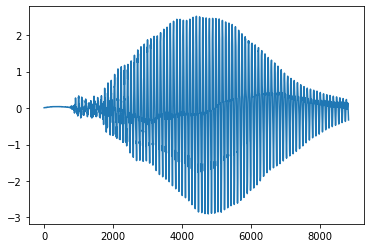

In [13]:
plt.plot(normalized)

Restrictedaudio above will be one type of array which we will be saving.
Afterwards we can play around with it and turn into images, etc. But for now
make a folder in which to save all those things!

In [ ]:
#assert the length will be at least 8000 or whatever?

In [ ]:
# ANOTHER NOTE: CSV FILES ARE VERY HEAVY AND WEIGH MORE THAN ORIGINAL MP3. IS THERE A BETTER WAY?

#spectrogram = tfio.audio.spectrogram(normalized, nfft=512, window=512, stride=256)

# Pre-processing data

In [ ]:
# Next: Turn all of the MP3 files into data types like the previous section.
# Then normalize image data. Make sure both that:
# 1: Amplitudes go from 0 to 1?
# 2: Lengths are the same?

In [7]:
#make functions nicer later! (add domain and range, as well as function descriptions)
def io_to_array(io_tensor):
  trimmed_tensor = io_tensor[10:]
  squeezed_tensor = tf.squeeze(trimmed_tensor)
  return np.array(squeezed_tensor)

def restricted_audio(rate, duration, audio):
  points = rate * duration
  middle = np.argmax(audio)
  begin = int(middle-points/2)
  end = int(middle+points/2)
  return audio[begin:end]

In [ ]:
normalarrays = []
for i in range(0,len(normalnotes)-1):
  path = 'Instruments/Instruments_test/' + normalnotes[i]
  iofile = tfio.audio.AudioIOTensor(path)
  normalarrays.append(io_to_array(iofile))
  if i %100 == 0:
    print (str(i) + ' done!') 

In [95]:
np.save('normal_arrays_test', normalarrays, allow_pickle = 'True')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Start from here!
I now have the data.
Need to normalize, and maybe trim to have same length forall?

In [40]:
# establish minimum length of audio. maybe 0.5 seconds? this is 22k approx
smallest = 20000
k = 0
for i in normalarrays:
  if len(i) < smallest:
    k+=1
print(k)
#ISSUE: all arrays in normalarrays seem to be the same size. but for different notes, we should have different durations! did i use 
#figure out min length of array in normalarrays list!

957


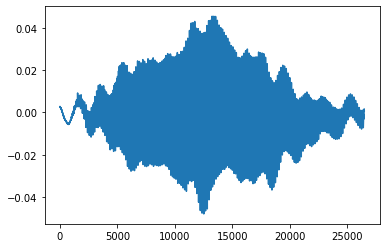

In [35]:
arraysample1 = io_to_array(audiosample1)
restrictedsample1 = restricted_audio(rate1, 3*duration1, arraysample1)
plt.plot(restrictedsample1)

#lesson: different audio files might require very different durations for us to get a decent idea!!
#do we do different durations depending on the file? or do we do the max possible duration for all? (this would require knowing the samllest file)
#conceptual issue: maybe we can't hear more modes in 0.2 seconds, but perhaps the timbre is specified by longer time scales as well? or vibrato, etc...

In [ ]:
train_names = os.listdir('Instruments/Instruments_train/')

In [ ]:
np.savetxt('testcase.csv', spectrogram, delimiter=',')

In [ ]:
# Up next: restrict to a smaller subset of the data! Maybe only 100 (random) sounds for each instrument is enough.
# Then see what happens as size of data set changes to experiment with that.

In [ ]:
spectrograms = []
for i in np.arange(0, len(train_names)):
  path = 'Instruments/Instruments_train/' + filesamplename[i]
  audio = tfio.audio.AudioIOTensor(path)
  audio = audio[10:] # What does this do?!
  audio = tf.squeeze(audio, axis=[-1])
  audio = np.array(audio)
  spectrogram = tfio.audio.spectrogram(audiosample1, nfft=512, window=512, stride=256)
  spectrograms.append(spectrogram)
  if i % 100 == 0:
    print('Done with ' + str(i) + '!')
  np.savetxt('Instruments/Instruments_train/spectrogram_' + filesamplename[i] + '.csv' , spectrogram, delimiter=',')

np.savetxt('spectrograms.csv', spectrograms, delimiter=',')

In [ ]:
# Plot a few spectrograms to check it's all ok!

# Defining the model